In [1]:
# Import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Import ML libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, f1_score, plot_precision_recall_curve, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#import bootstrap libs
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

#dummy classifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

In [2]:
# Load data
train_merged = pd.read_csv('./data/train_merged.csv')
test_merged = pd.read_csv('./data/test_merged.csv')
submission = pd.read_csv('./data/sampleSubmission.csv')

In [3]:
train_merged.head(1)

,date,latitude,longitude,nummosquitos,wnvpresent,street_ W ARMITAGE AVENUE,street_ E 105TH ST,street_ E 111TH ST,street_ E 115TH ST,street_ E 118TH ST,...,coolsq,preciptotalsq,resultspeedsq,resultdirsq,avgspeedsq,daylightminssq,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHERS
0,2007-05-29,41.95469,-87.800991,1,0,0,0,0,0,0,...,81.0,0.0,33.64,324.0,42.25,802816.0,0,1,0,0


## Baseline Model

In [9]:
#define X, y
X = train_merged.drop(columns = ['wnvpresent','date'])
y = train_merged['wnvpresent']

In [10]:
baseline = y.value_counts(normalize=True)

In [11]:
print(f'Imbalanced Data Baseline Accuracy: {baseline[0].round(3)}%')

Imbalanced Data Baseline Accuracy: 0.947%


In [12]:
print(f"Balanced Data Baseline Accuracy: 0.5%")

Balanced Data Baseline Accuracy: 0.5%


## Train Test Split

In [13]:
#split train test 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

## Pipeline

Pipeline with oversampling bootstrapping (SMOTE). Metric is using recall as we are trying to identify the true positive rate. 

In this scenario, the identification of the true cases (WNV Present) to the False Negative (Type II error where predicted to be not present proved to be otherwise) in order to better naviagte resources to the location for pesticide control.

### Logistic Regression

In [14]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

#set pipe params
pipe_params = {
    'logreg__solver' : ['liblinear','lbfgs'],
    'logreg__C': np.logspace(-2, 1, 1),
    'logreg__class_weight':["balanced",]
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='recall')
#fit model
gs.fit(X_train, y_train)
best_logreg = gs.best_estimator_

print('Training Recall: ', best_logreg.score(X_train, y_train))
print('Testing Recall: ', best_logreg.score(X_test, y_test))
print('\n')
gs.best_params_

Training Recall:  0.7743629145857344
Testing Recall:  0.7580645161290323




{'logreg__C': 0.01,
 'logreg__class_weight': 'balanced',
 'logreg__solver': 'liblinear'}

### K Nearest Neighbours

In [15]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

#set pipe params
pipe_params = {
    'knn__n_neighbors' : [3,5,7,10],
    'knn__weights' : ['uniform','distance'],
    'knn__p': [1,2]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='recall')
#fit model
gs.fit(X_train, y_train)
best_knn = gs.best_estimator_

print('Training Recall: ', best_knn.score(X_train, y_train))
print('Testing Recall: ', best_knn.score(X_test, y_test))
print('\n')
gs.best_params_

Training Recall:  0.8565757459341785
Testing Recall:  0.7872503840245776




{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}

### Random Forest

In [46]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, bootstrap=True))
])

#set pipe params
pipe_params = {
    'rf__n_estimators': [100,150],
    'rf__max_depth': [3,9,10]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_

print('Training Accuracy: ', best_rf.score(X_train, y_train))
print('Testing Accuracy: ', best_rf.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.8113714944295044
Testing Accuracy:  0.7953149001536098




{'rf__max_depth': 9, 'rf__n_estimators': 150}

In [16]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Balanced Baseline','Logistic Regression','K Nearest Neighbors','Random Forest'],
    'Training Recall' : [0.5, best_logreg.score(X_train, y_train),best_knn.score(X_train, y_train),best_rf.score(X_train, y_train)],
    'Test Recall' : [0.5 ,best_logreg.score(X_test, y_test),best_knn.score(X_test, y_test),best_rf.score(X_test, y_test)]
})

model_df

,Model,Training Recall,Test Recall
0,Balanced Baseline,0.500000,0.500000
1,Logistic Regression,0.657831,0.650154
2,K Nearest Neighbors,0.870534,0.824117
3,Random Forest,0.826226,0.804147


## Model Selection

Based on the training and test set recall score, the best model with the best score is .... (RF for now)

In [17]:
#model selection and prediction for validation 
best_model = best_rf
best_model.fit(X_train,y_train)

#predict all datasets
y_preds = best_model.predict(X)

In [18]:
#compare ytest and prediction
pred_df = pd.DataFrame({'true_values': y,
                        'preds_values': y_preds})

pred_df.head()

,true_values,preds_values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


### F1 Score

In [19]:
f1_score(y, y_preds)

0.30928597854236034

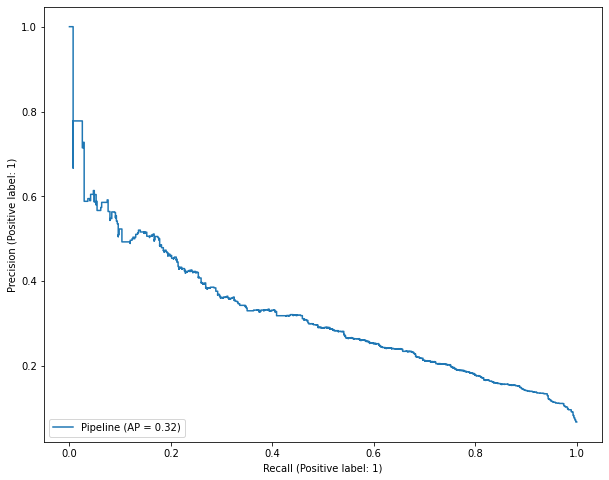

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_precision_recall_curve(best_model,X,y,ax=ax)
plt.show()

## Model Evaluation

### Confusion Matrix

In [21]:
#plot cm to check for prediction accuracy
cm = confusion_matrix(y,y_preds)

In [22]:
tn,fp,fn,tp = confusion_matrix(y, y_preds).ravel()

In [23]:
print(f'True Negatives: {tn}') #predict absent is absent
print(f'False Positives: {fp}') #predict present but absent
print(f'False Negatives: {fn}') #predict absent but present
print(f'True Positives: {tp}') #predict present is present

True Negatives: 8128
False Positives: 1734
False Negatives: 133
True Positives: 418


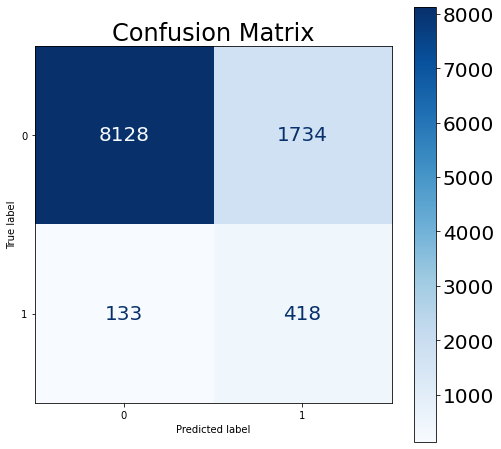

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(best_model, X, y, cmap= 'Blues', 
                  values_format='d', ax=ax );
plt.title('Confusion Matrix')
plt.show()

*Confusion matrix plotted for Predicted and True Values for Class 1 (WNV Present) to Class 0 (No WNV Present) demonstrates the specificity and sensitivity of the model.*

In [25]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp/(fp+tp)

In [26]:
print("Sensitivity: ", round(sensitivity,2))
print("Specificity: ", round(specificity,2))
print("Precision:", round(precision,2))

Sensitivity:  0.76
Specificity:  0.82
Precision: 0.19


In this problem statement, the concern on the model prediction will be the false negative, also known as Type II error. With specificity/ recall at 0.89, and sensitivity at 0.78 the model is able to identify the true positive rate and true negative rate accordingly.

However, the precision score is low at 0.29 only. This means the model has been predicting cases as positive more than it should have been. 

### ROC AUC

In [27]:
TPR = sensitivity
print("True Positive Rate: ", round(TPR,2))
TNR = 1 - specificity
print("True Negative Rate (False Positive Rate)", round(TNR,2))

True Positive Rate:  0.76
True Negative Rate (False Positive Rate) 0.18


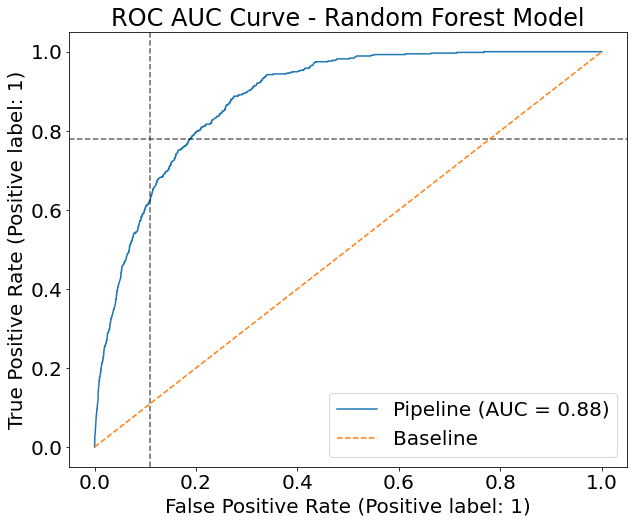

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(best_model,X,y,ax=ax)
plt.axvline(0.11, color='k',linestyle='--',alpha=0.6)
plt.axhline(0.78, color='k',linestyle='--',alpha=0.6)
plt.plot([0,1],[0,1], color='tab:orange', linestyle='--', label='Baseline')

plt.title('ROC AUC Curve - Random Forest Model')
plt.legend()
plt.show()

### Model Threshold Adjustment

In [29]:
#y_test vs predict proba
pred_prob_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': best_model.predict_proba(X_test)[:,1]})

pred_prob_df.head()

,true_values,pred_probs
4459,0,0.000000
4099,0,0.000000
4423,0,0.002469
521,0,0.000591
10393,0,0.431816


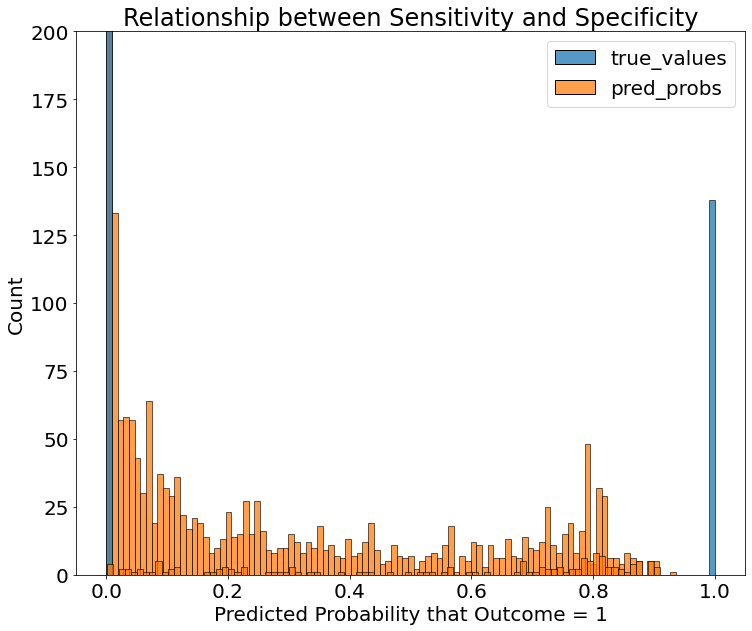

In [30]:
plt.figure(figsize = (12, 10))

# plot distributions of predicted probabilities by actual values
for group in pred_prob_df.groupby('true_values'):
    sns.histplot(group[1], kde = False, bins = 100)

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title('Relationship between Sensitivity and Specificity')
plt.ylim(0,200)
plt.show()

In [31]:
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

In [32]:
threshold_list = [0.45, 0.5, 0.55, 0.6]

for threshold in threshold_list:
    preds = get_predictions(best_model.predict_proba(X_test)[:,1], threshold)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f'Threshold: {threshold:.2f}, Recall: {rec:.2f}, Precision: {prec:.2f}, f1 : {f1:.2f}')

Threshold: 0.45, Recall: 0.63, Precision: 0.15, f1 : 0.24
Threshold: 0.50, Recall: 0.62, Precision: 0.16, f1 : 0.25
Threshold: 0.55, Recall: 0.59, Precision: 0.16, f1 : 0.25
Threshold: 0.60, Recall: 0.56, Precision: 0.17, f1 : 0.26


In [33]:
best_rf

Pipeline(steps=[('ss', StandardScaler()),
                ('oversample', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=10, max_features=10,
                                        min_samples_leaf=2, random_state=42))])

In [34]:
# Extracting feature importances
rf = RandomForestClassifier(max_depth=15, n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=150)

In [35]:
rf.feature_importances_

array([0.33865459, 0.34361442, 0.01870003, 0.0161127 , 0.01293846,
       0.01259371, 0.01503499, 0.01224378, 0.00126793, 0.01235812,
       0.00633176, 0.01238543, 0.01287786, 0.01601709, 0.01792273,
       0.0180564 , 0.046894  , 0.03061491, 0.03207041, 0.01987546,
       0.00343523])

In [36]:
df_fi = pd.DataFrame(zip(col_model, rf.feature_importances_))

In [37]:
df_fi.head()

,0,1
0,latitude,0.338655
1,longitude,0.343614
2,tmax,0.018700
3,tmin,0.016113
4,tavg,0.012938


In [63]:
df_fi.sort_values(by = 1, ascending = False).head(20)

,0,1
1,longitude,0.343614
0,latitude,0.338655
16,daylightmins,0.046894
18,species_CULEX PIPIENS/RESTUANS,0.032070
17,species_CULEX PIPIENS,0.030615
19,species_CULEX RESTUANS,0.019875
2,tmax,0.018700
15,avgspeed,0.018056
14,resultdir,0.017923
3,tmin,0.016113


In [49]:
X_test = test_merged[col_model]

In [52]:
kaggle_score = pd.DataFrame(zip(test_merged.id, gs.predict(X_test)))

In [ ]:
kaggle_score.to_csv('')

In [55]:
kaggle_score.rename(columns = {0:"Id", 1: "WnvPresent"}, inplace = True)

AttributeError: 'DataFrame' object has no attribute 'wnvpresent'

In [57]:
test_merged.id.head()

0    1
1    2
2    3
3    4
4    5
Name: id, dtype: int64

In [61]:
kaggle_score.to_csv('./data/submission_1.csv', index= False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf97d729-91d2-44aa-ae54-5374473494d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>